#Introduction to Micrometereology for Wind Energy
## Assignment 1 - Weibull Distribution

#### by Juan P. Murcia (jumu@dtu.dk)

Wind resources measurements from a 70 m mast at the island of Sprog (Denmark) are analyized. The 10-min averaged wind speed at 70 m, and the 10-min averaged wind direction in degrees at 67.5 m and 70 m have been recorded during the 1977-09-13 to 1999-09-08 period. The wind direction measurements are not available during the same periods of time.

## Load Data from tsv file

The in first step in the analysis is to load the data and to filter all the erroneous measurements. Invalid speed data are indicated as 99.99 while invalid directions by 999.9.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import scipy as sp
import time as tm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.dates as dates

from scipy.stats import weibull_min
from scipy.special import gamma

import pymc as pm  # PyMC3

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
metMastTable = pd.DataFrame.from_csv('sprog.tsv', sep ='\t')

In [4]:
metMastTable.ws_70.replace(to_replace =99.99,value=NaN,inplace=True)
metMastTable.wd_67p5.replace(to_replace =999,value=NaN,inplace=True)
metMastTable.wd_70.replace(to_replace =999,value=NaN,inplace=True)

To detect the periods of availability of each wind vane senor, the whole time series are plotted. From this plot it can be observed that the wind direction sensor at 67.5 m was available from 1977-09-13 (14:35:00) to 1988-06-13 (09:45:00), while the wind vane at 70 m was available from 1989-01-09 (00:05:00) to 1999-09-08 (07:15:00). The anemometer at 70 m is available for the whole period of time with some individual erroneous data points.

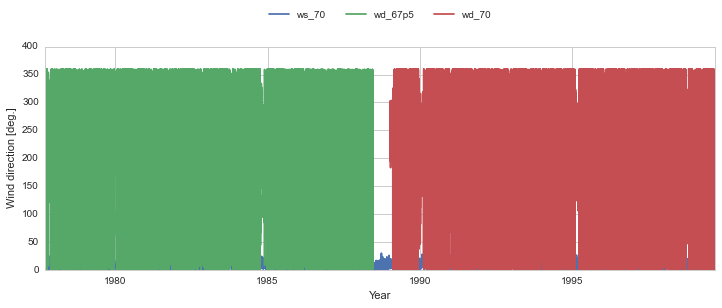

In [5]:
fig,ax = plt.subplots(1, 1)
fig.set_size_inches(12,4)
ax = metMastTable.plot(ax=ax)
ax.set_ylabel('Wind direction [deg.]')
ax.set_xlabel('Year')
lgd = ax.legend(loc='upper center',bbox_to_anchor=(0.5, 1.2),fancybox=True, shadow=False, ncol=3)
print

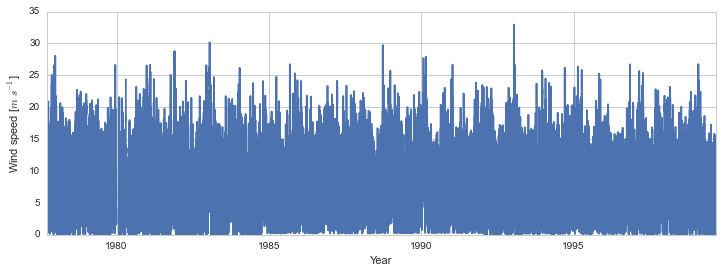

In [6]:
fig,ax = plt.subplots(1, 1)
fig.set_size_inches(12,4)
ax = metMastTable.ws_70.plot(ax=ax)
ax.set_ylabel(r'Wind speed [$m \,s^{-1}$]')
ax.set_xlabel('Year')
print

In [7]:
metMastTable_67p5 = metMastTable[np.isfinite(metMastTable['wd_67p5'])]
metMastTable_70 = metMastTable[np.isfinite(metMastTable['wd_70'])]

### 1. Mean wind speed statistics

The mean wind speed statistics for the whole recording period are presented in the following table:

In [8]:
print 'mean(ws) [m/s] = '+'%0.2f'%(metMastTable.ws_70.mean())
print 'std(ws)  [m/s] = '+'%0.2f'%(metMastTable.ws_70.var())
print 'skew(ws) [-]   = '+'%0.2f'%(metMastTable.ws_70.skew())
print 'min(ws)  [m/s] = '+'%0.2f'%(metMastTable.ws_70.min())
print 'max(ws)  [m/s] = '+'%0.2f'%(metMastTable.ws_70.max())
print 'N count  [-]   = '+ '%s'%(metMastTable.ws_70.count())



mean(ws) [m/s] = 8.24
std(ws)  [m/s] = 15.27
skew(ws) [-]   = 0.41
min(ws)  [m/s] = 0.00
max(ws)  [m/s] = 32.97
N count  [-]   = 1133028


### 2. Mean wind speed PDF 
The mean wind speed PDF can be represented using a normalized histogram. See the next figure. Here the bins of the histogram are defined as the standard wind speed bins used in wind energy: 1 m/s wide and with even starting and end points. Similar approach is used to define the CDF based on cumulative histogram.

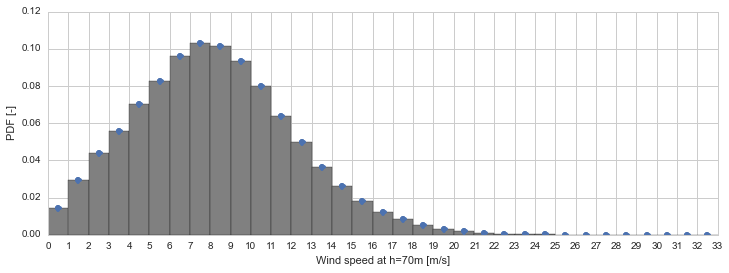

In [9]:
(n_ws, bins_ws, patches_ws) = plt.hist(metMastTable.ws_70,bins=np.arange(0,34),
                                       color='grey',normed=True, align='mid')
x_ws = 0.5*(bins_ws[:-1]+bins_ws[1:])
plt.plot(x_ws,n_ws,'o')
plt.xlabel('Wind speed at h=70m [m/s]')
plt.ylabel('PDF [-]')
fig = plt.gcf()
fig.set_size_inches(12,4)
ax = plt.gca()
ax.set_xlim([0,33])
ax.set_xticks(range(0,34))
print

### 3. Mean wind speed CDF

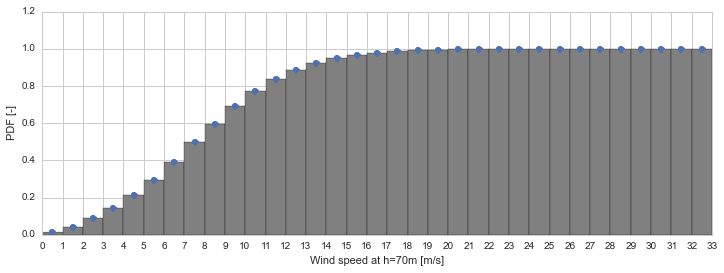

In [10]:
(n_cdf_ws, bins_ws, patches_ws) = plt.hist(metMastTable.ws_70,bins=np.arange(0,34),color='grey',
                                       normed=True, align='mid', cumulative=True)
plt.plot(0.5*(bins_ws[:-1]+bins_ws[1:]),n_cdf_ws,'o')
plt.xlabel('Wind speed at h=70m [m/s]')
plt.ylabel('PDF [-]')
fig = plt.gcf()
fig.set_size_inches(12,4)
ax = plt.gca()
ax.set_xlim([0,33])
ax.set_xticks(range(0,34))
print

Error bars can be associated to each bin, assuming that the mean bin CDF is normally distributed inside each bin.

In [11]:
N_bin = n_cdf_ws*metMastTable.ws_70.count()
y_err_ws = 0*N_bin
for i in range(len(N_bin)-1):
    #Gaussian distribution of the bin mean value
    y_err_ws[i]=np.std(metMastTable.ws_70[metMastTable.ws_70<bins_ws[i+1]])/np.sqrt(N_bin[i])

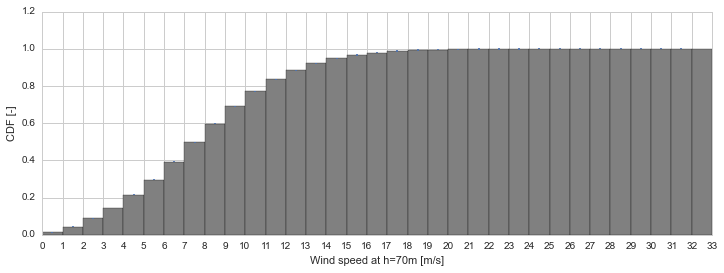

In [12]:
plt.bar(x_ws-.5,n_cdf_ws,width=1, color='grey', yerr=y_err_ws)
plt.xlabel('Wind speed at h=70m [m/s]')
plt.ylabel('CDF [-]')
fig = plt.gcf()
fig.set_size_inches(12,4)
ax = plt.gca()
ax.set_xlim([0,33])
ax.set_xticks(range(0,34))
print

### 4. Weibull distribution fit to mean wind speed measurements

There exist several methodologies in order to fit a Weibull distribution into the the mean wind speed measurements. In this report 4 differenet methodologies are used: mean and variance least error, mean and skewness least error, linear fit of the double logarithm of the CDF and the Maximum likelihood estimation.

#### a) Mean and Variance Based Weibull Fit

Iterativelly fit the weibull function based on the mean and variance

- Expected: $\mathbb{E}(x) = A \, \left[ \Gamma \left(1 + \dfrac{1}{k} \right) \right]$
- Variance: $\mathbb{V}(x) = A^2 \, \left[ \Gamma \left(1 + \dfrac{2}{k} \right) - \Gamma^2 \left(1 + \dfrac{1}{k} \right) \right]$

In order to implement this method, the squared error (SE) in the mean and variance estimations are used as error function to be minimized.

In [13]:
def weibull_EV(x,E,V):
    A=x[0]; k=x[1]
    out=[0,0]
    out[0] = ( A*gamma(1.0+1.0/k) - E )**2.0
    out[1] = ( A**2*( gamma(1.0+2.0/k) - (gamma(1.0+1.0/k))**2.0 ) - V )**2.0
    return out

In [14]:
E = metMastTable.ws_70.mean()
V = metMastTable.ws_70.var()
A_EV,k_EV = sp.optimize.fsolve(weibull_EV, [10,2],args=(E,V), xtol=1e-6, maxfev=10000)
print '-------------------------'
print 'Mean and variance error'
print '-------------------------'
print
print 'Shape, k\t'+'Scale, A'
print '[-]\t\t'+'[m/s]\t\t'
print '-------------------------'
print '%0.4f\t\t%0.4f\t\t' % (k_EV, A_EV)
print
print 'mean-SE\t\t'+'Var-SE'
print '[m/s]^2\t\t'+'[m/s]^4\t\t'
print '-------------------------'
print '%0.2e\t%0.2e\t\t' % (weibull_EV([A_EV,k_EV],E,V)[0],weibull_EV([A_EV,k_EV],E,V)[1])

-------------------------
Mean and variance error
-------------------------

Shape, k	Scale, A
[-]		[m/s]		
-------------------------
2.2275		9.2987		

mean-SE		Var-SE
[m/s]^2		[m/s]^4		
-------------------------
6.14e-14	1.41e-13		


In [15]:
pdf_ws_EV_fit = weibull_min.pdf(x_ws, c=k_EV, scale=A_EV)

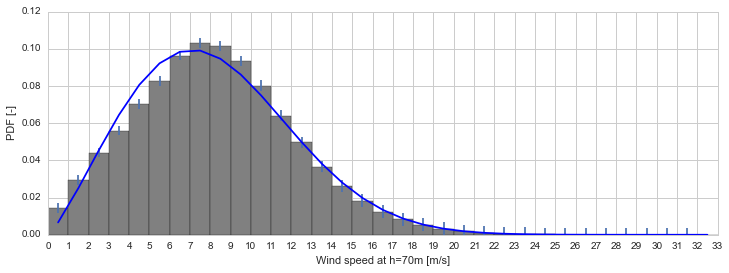

In [16]:
plt.bar(x_ws-0.5,n_ws,width=1, color='grey', yerr=y_err_ws)
plt.plot(x_ws,pdf_ws_EV_fit,'-b')
plt.ylim([0,0.12])
plt.xlabel('Wind speed at h=70m [m/s]')
plt.ylabel('PDF [-]')
fig = plt.gcf()
fig.set_size_inches(12,4)
ax = plt.gca()
ax.set_xlim([0,33])
ax.set_xticks(range(0,34))
print

#### b) Mean and Skewness Based Weibull Fit

Iterativelly fit the weibull function based on the mean and variance

- Expected: $\mathbb{E}(x) = A \, \left[ \Gamma \left(1 + \dfrac{1}{k} \right) \right]$
- Variance: $\mathbb{V}(x) = A^2 \, \left[ \Gamma \left(1 + \dfrac{2}{k} \right) - \Gamma^2 \left(1 + \dfrac{1}{k} \right) \right]$
- Skewness: $\mathbb{S}(x) = \dfrac{ A^3 \, \left[ \Gamma \left(1 + \dfrac{3}{k} \right) \right] - 3 \,\mathbb{E} \, \mathbb{V} - \mathbb{E}^3 }{\sigma^3}$

In order to implement this method, the squared error (SE) in the mean and skewness estimations are used as error function to be minimized.


In [17]:
def weibull_EVSk(x,E,V,Sk):
    A=x[0]; k=x[1]
    out=[0,0]
    out[0] = ( A*gamma(1+1/k) - E )**2
    out[1] = ( (A**3.0*gamma(1+3/k) - 3.0*E*( A**2*( gamma(1.0+2.0/k) - (gamma(1.0+1.0/k))**2.0 ) ) - E**3.0)/( A**2*( gamma(1.0+2.0/k) - (gamma(1.0+1.0/k))**2.0 ) )**1.5 - Sk )**2.0
    return out

In [18]:
E  = metMastTable.ws_70.mean()
V  = metMastTable.ws_70.var()
Sk = metMastTable.ws_70.skew()
A_EVSk, k_EVSk = sp.optimize.fsolve(weibull_EVSk, [10,2],args=(E,V,Sk), xtol=1e-6, maxfev=1000)
print '-------------------------'
print 'Mean and Skewness error'
print '-------------------------'
print
print 'Shape, k\t'+'Scale, A'
print '[-]\t\t'+'[m/s]\t\t'
print '-------------------------'
print '%0.4f\t\t%0.4f\t\t' % (k_EVSk, A_EVSk)
print
print 'mean-SE\t\t'+'Sk-SE'
print '[m/s]^2\t\t'+'[-]\t\t'
print '-------------------------'
print '%0.2e\t%0.2e\t\t' % (weibull_EVSk([A_EVSk,k_EVSk],E,V,Sk)[0],weibull_EVSk([A_EVSk,k_EVSk],E,V,Sk)[1])

-------------------------
Mean and Skewness error
-------------------------

Shape, k	Scale, A
[-]		[m/s]		
-------------------------
2.3911		9.2908		

mean-SE		Sk-SE
[m/s]^2		[-]		
-------------------------
5.63e-13	8.32e-13		


In [19]:
pdf_ws_EVSk_fit = weibull_min.pdf(x_ws, c=k_EVSk, scale=A_EVSk)

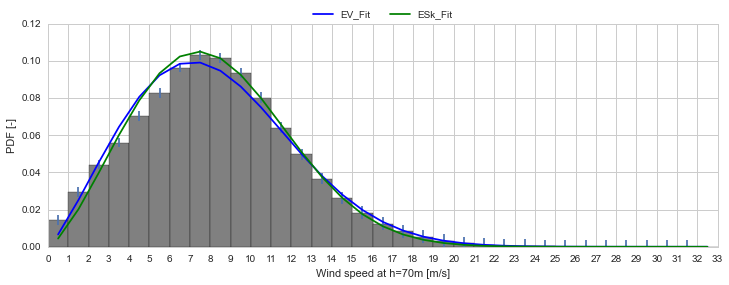

In [20]:
plt.bar(x_ws-0.5,n_ws,width=1, color='grey', yerr=y_err_ws)
plt.plot(x_ws,pdf_ws_EV_fit,'-b',label='EV_Fit')
plt.plot(x_ws,pdf_ws_EVSk_fit,'-g',label='ESk_Fit')
plt.ylim([0,0.12])
plt.xlabel('Wind speed at h=70m [m/s]')
plt.ylabel('PDF [-]')
fig = plt.gcf()
fig.set_size_inches(12,4)
ax = plt.gca()
ax.set_xlim([0,33])
ax.set_xticks(range(0,34))
ax.legend(loc='upper center',bbox_to_anchor=(0.5, 1.1),fancybox=True, shadow=False, ncol=4)
print

#### c) Double logarithm of the CDF

Based on the CDF of a Weibull a process can be perfromed to perform a fit using a linear regression (usually based on least squared errors).

$F(x) = 1 - \exp \left( - \left[ \frac{x}{A} \right]^k \right) $

$ - \left[ \frac{x}{A} \right]^k = \ln \left( 1 - F(x) \right) $ 

$ \left[ \frac{x}{A} \right]^k = - \ln \left( 1 - F(x) \right) $ 

$ k \, \ln \left( x \right) - k \, \ln \left(A \right) =  \ln \left(  - \ln \left( 1 - F(x) \right) \right) $ 

$ k \, \hat{x} - k \, \ln \left(A \right) =   \hat{y} $ 


In [39]:
imin=4
xx = np.log(x_ws[imin:-1])
yy = np.log( - np.log(1 - n_cdf_ws[imin:-1]))
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(xx, yy)
print 'slope\t\t'+'intercept\t'+'r_value\t\t'+'p_value\t\t\t'+'std_err\t\t'
print slope,'\t',intercept,'\t',r_value,'\t',p_value,'\t',std_err

slope		intercept	r_value		p_value			std_err		
2.10372026572 	-4.57974091574 	0.999596184714 	9.61760842795e-42 	0.0117284130919


In [40]:
k_LL = slope
A_LL = np.exp(-intercept/k_LL)
print '-------------------------'
print 'Double log Method'
print '-------------------------'
print
print 'Shape, k\t'+'Scale, A'
print '[-]\t\t'+'[m/s]\t\t'
print '-------------------------'
print '%0.4f\t\t%0.4f\t\t' % (k_LL, A_LL)
print
print 'R^2 goodness of fit: ', '%0.4f' %(r_value**2)

-------------------------
Double log Method
-------------------------

Shape, k	Scale, A
[-]		[m/s]		
-------------------------
2.1037		8.8196		

R^2 goodness of fit:  0.9992


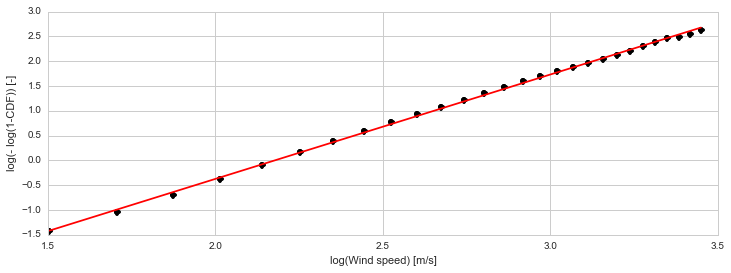

In [41]:
plt.plot(xx,yy,'ok')
plt.plot(xx,slope*xx+intercept,'-r')
plt.xlabel('log(Wind speed) [m/s]')
plt.ylabel('log(- log(1-CDF)) [-]')
fig = plt.gcf()
fig.set_size_inches(12,4)
plt.plot()
print

In [42]:
pdf_ws_LL_fit = weibull_min.pdf(x_ws, c=k_LL, scale=A_LL)

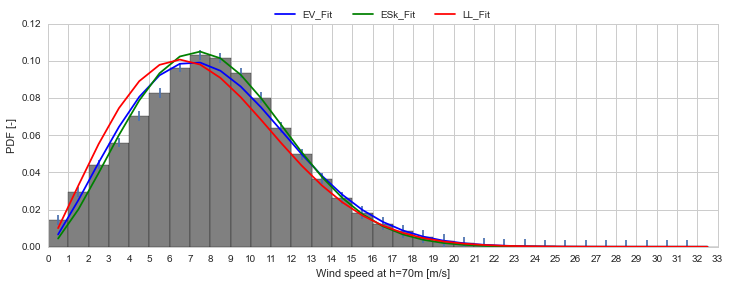

In [43]:
plt.bar(x_ws-0.5,n_ws,width=1, color='grey', yerr=y_err_ws)
plt.plot(x_ws,pdf_ws_EV_fit,'-b',label='EV_Fit')
plt.plot(x_ws,pdf_ws_EVSk_fit,'-g',label='ESk_Fit')
plt.plot(x_ws,pdf_ws_LL_fit,'-r',label='LL_Fit')
plt.ylim([0,0.12])
plt.xlabel('Wind speed at h=70m [m/s]')
plt.ylabel('PDF [-]')
fig = plt.gcf()
fig.set_size_inches(12,4)
ax = plt.gca()
ax.set_xlim([0,33])
ax.set_xticks(range(0,34))
ax.legend(loc='upper center',bbox_to_anchor=(0.5, 1.1),fancybox=True, shadow=False, ncol=4)
print

#### d) Maximum Likelihood Estimation (MLE)

MLE estimation consist in finding the distribution parameters $A$ and $k$, that maximize the likelihood function. This function is the probability of observing a measurement given a set of parameters, which means that it takes the same values as the PDF. 

$\mathcal{L}(A,k|y) = \text{PDF}(y|A,k)$

The maximum likelihood estimation method consist in finding the parameters that maximize the total likelihood of all the measurements. This method is the most computationally demanding due to the need to evaluate the likelihood function for each observation while varying the shape and scale parameters  of the Weibull function.

In [44]:
k_MLE,loc,A_MLE= weibull_min.fit(np.sort(metMastTable.ws_70[metMastTable.ws_70>=0].values),
                                 floc=0,shape=2,scale=10)

In [45]:
print 'Shape, k\t'+'Scale, A'
print '[-]\t\t'+'[m/s]\t\t'
print '-------------------------'
print '%0.4f\t\t%0.4f\t\t' % (k_MLE,A_MLE)

Shape, k	Scale, A
[-]		[m/s]		
-------------------------
2.2103		9.2896		


In [46]:
pdf_ws_MLE_fit = weibull_min.pdf(x_ws, c=k_MLE, scale=A_MLE)

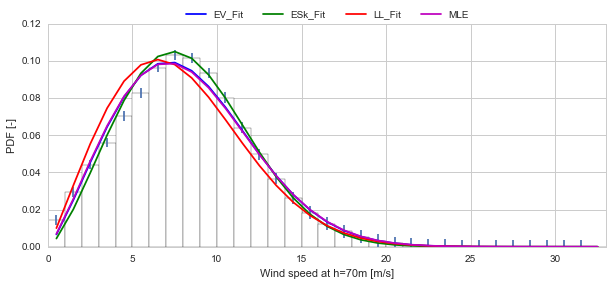

In [47]:
plt.bar(x_ws-0.5,n_ws,width=1, color='white', yerr=y_err_ws)
plt.plot(x_ws,pdf_ws_EV_fit,'-b',label='EV_Fit')
plt.plot(x_ws,pdf_ws_EVSk_fit,'-g',label='ESk_Fit')
plt.plot(x_ws,pdf_ws_LL_fit,'-r',label='LL_Fit')
plt.plot(x_ws,pdf_ws_MLE_fit,'-m',label='MLE')
plt.ylim([0,0.12])
plt.xlabel('Wind speed at h=70m [m/s]')
plt.ylabel('PDF [-]')
fig = plt.gcf()
fig.set_size_inches(10,4)
ax = plt.gca()
ax.set_xlim([0,33])
#ax.set_xticks(range(0,34))
ax.legend(loc='upper center',bbox_to_anchor=(0.5, 1.1),fancybox=True, shadow=False, ncol=4)
print

### 5) Least square error (of histogram) fit

Iterativelly fit the weibull function based on the mean and variance 

$\arg \min_{A,k} \text{SSE} = \arg \min \sum\limits_{i=0}^{N_{bins}} \left[ \text{PDF}_i(A,k) - f_i \right]^2$


In [173]:
def weibull_SSE(x,x_ws,n_ws):
    A=x[0]; k=x[1]; out = [0.0]
    PDF = weibull_min.cdf(bins_ws[1:], c=k, scale=A) - weibull_min.cdf(bins_ws[:-1], c=k, scale=A)
    out[0] = np.sum( (PDF-n_ws)**2 )
    return out

In [174]:
out = sp.optimize.minimize(weibull_SSE, x0=[10,3],args=(x_ws,n_ws), tol=1e-6, method='SLSQP')
print out
A_LSE = out.x[0]
k_LSE = out.x[1]
print
print 'Shape, k\t'+'Scale, A'
print '[-]\t\t'+'[m/s]\t\t'
print '-------------------------'
print '%0.4f\t\t%0.4f\t\t' % (k_LSE, A_LSE)

  status: 0
 success: True
    njev: 15
    nfev: 60
     fun: [0.00034894832446696525]
       x: array([ 9.4574119 ,  2.33317196])
 message: 'Optimization terminated successfully.'
     jac: array([ -9.72431735e-06,  -5.03391493e-06,   0.00000000e+00])
     nit: 15

Shape, k	Scale, A
[-]		[m/s]		
-------------------------
2.3332		9.4574		


In [175]:
pdf_ws_SSE_fit = weibull_min.pdf(x_ws, c=k_LSE, scale=A_LSE)

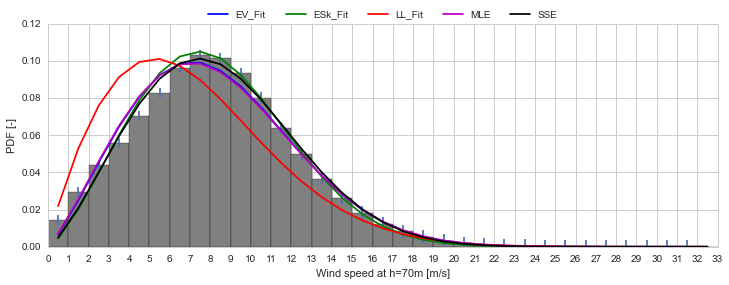

In [176]:
plt.bar(x_ws-0.5,n_ws,width=1, color='grey', yerr=y_err_ws)
plt.plot(x_ws,pdf_ws_EV_fit,'-b',label='EV_Fit')
plt.plot(x_ws,pdf_ws_EVSk_fit,'-g',label='ESk_Fit')
plt.plot(x_ws,pdf_ws_LL_fit,'-r',label='LL_Fit')
plt.plot(x_ws,pdf_ws_MLE_fit,'-m',label='MLE')
plt.plot(x_ws,pdf_ws_SSE_fit,'-k',label='SSE')
plt.ylim([0,0.12])
plt.xlabel('Wind speed at h=70m [m/s]')
plt.ylabel('PDF [-]')
fig = plt.gcf()
fig.set_size_inches(12,4)
ax = plt.gca()
ax.set_xlim([0,33])
ax.set_xticks(range(0,34))
ax.legend(loc='upper center',bbox_to_anchor=(0.5, 1.1),fancybox=True, shadow=False, ncol=5)
print


#### 6) Bayesian Inference of Weibull parameters

In [190]:
with pm.Model() as ABL_Weibul_model:

    #prior for scale parameter 
    A = pm.Uniform('A', 6, 12) #        A = pm.Normal('A', mu=9, sd=0.01) #    
    #prior for shape parameter 
    K = pm.Uniform('K', 1, 3) #         K = pm.Normal('K', mu=2.25, sd=0.01) #  

    #Models
    u_bar = pm.Weibull('u_bar', K, A, observed=metMastTable.ws_70[metMastTable.ws_70>0].values )   #10 mean wind speed       

    # Maximum aposteriori likelihood
    start = pm.find_MAP()

    # HMC sampling
    step = pm.NUTS(scaling=start)
    trace = pm.sample(2000, step, start=start)   

 [-----------------100%-----------------] 2001 of 2000 complete in 1960.7 sec

/Users/JPM/anaconda/lib/python2.7/site-packages/theano/gof/cmodule.py:284: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  rval = __import__(module_name, {}, {}, [module_name])


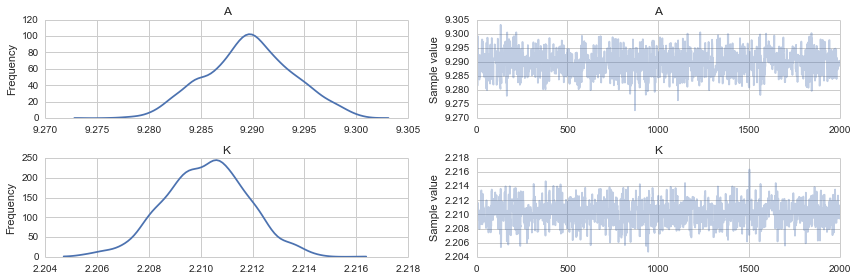

In [262]:
pm.traceplot(trace)
print

In [269]:
pdf_ws_Bay_fit = {}
for i in range(len(trace['K'])):
    pdf_ws_Bay_fit[i] = weibull_min.pdf(x_ws, c=trace['K'][i], scale=trace['A'][i])

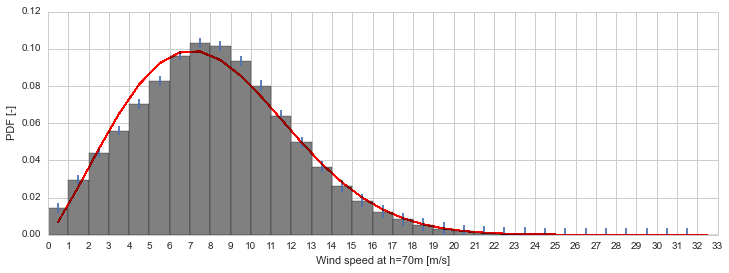

In [301]:
plt.bar(x_ws-0.5,n_ws,width=1, color='grey', yerr=y_err_ws)
#plt.hist(metMastTable.ws_70,bins=np.linspace(0,33,330),color='grey',normed=True, align='mid')
for i in range(len(trace['K'])):
    plt.plot(x_ws,pdf_ws_Bay_fit[i],'-r',alpha=0.01)
#plt.plot(x_ws,pdf_ws_EV_fit,'-b',label='EV_Fit')
#plt.plot(x_ws,pdf_ws_EVSk_fit,'-g',label='ESk_Fit')
#plt.plot(x_ws,pdf_ws_MLE_fit,'-m',label='MLE')
#plt.plot(x_ws,pdf_ws_SSE_fit,'-k',label='SSE')
plt.ylim([0,0.12])
plt.xlabel('Wind speed at h=70m [m/s]')
plt.ylabel('PDF [-]')
fig = plt.gcf()
fig.set_size_inches(12,4)
ax = plt.gca()
ax.set_xlim([0,33])
ax.set_xticks(range(0,34))
#ax.legend(loc='upper center',bbox_to_anchor=(0.5, 1.1),fancybox=True, shadow=False, ncol=5)
print

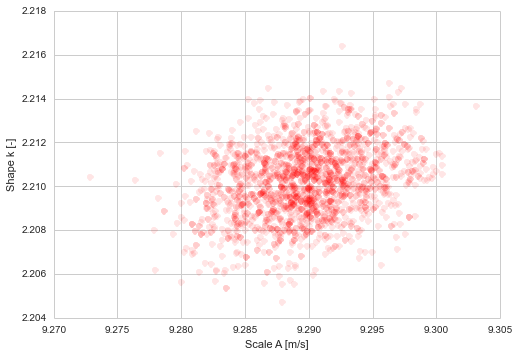

In [327]:
#plt.hexbin(trace['A'],trace['K'],gridsize=20)
plt.plot(trace['A'],trace['K'],'or',alpha=0.1)
plt.xlabel('Scale A [m/s]')
plt.ylabel('Shape k [-]')
print

#### 7) MC sampling - Yearly variation

In [299]:
N_boot = 10000

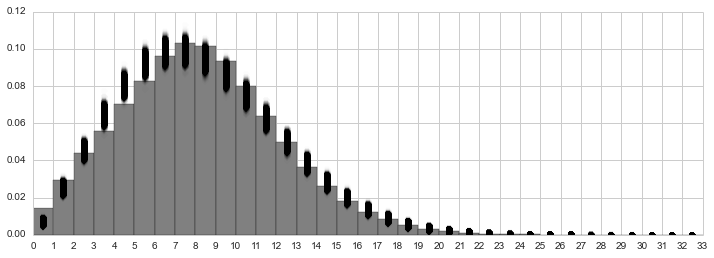

In [346]:
plt.hist(metMastTable.ws_70,bins=np.arange(0,34),
                                       color='grey',normed=True, align='mid') 
fig = plt.gcf()
fig.set_size_inches(12,4)
ax = plt.gca()
ax.set_xlim([0,33])
ax.set_xticks(range(0,34))

f_boot = np.zeros((33,N_boot)) #{}
for i in range(N_boot):
    f_boot[:,i], bins = np.histogram(weibull_min.rvs(c=k_EV, scale=A_EV,  size=8742),bins=np.arange(0,34), normed=True)
    ax.plot(x_ws,f_boot[:,i],'ok',alpha=0.01)


Very deficient fitting if the location parameter is not included!!

### MLE for Weibull with location parameter

In [338]:
k_MLE2,loc_MLE2,A_MLE2= weibull_min.fit(np.sort(metMastTable.ws_70[metMastTable.ws_70>=0].values),
                                 loc=0,shape=2,scale=10)

In [339]:
print 'k_MLE2 = ',k_MLE2
print 'A_MLE2 = ',A_MLE2
print 'loc_MLE2 = ',loc_MLE2
pdf_ws_MLE2_fit = weibull_min.pdf(x_ws, c=k_MLE2, loc=loc_MLE2, scale=A_MLE2)

k_MLE2 =  2.42575443004
A_MLE2 =  10.0502849462
loc_MLE2 =  -0.681133460123


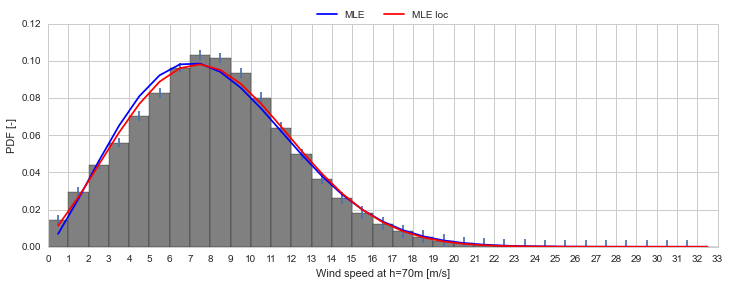

In [340]:
plt.bar(x_ws-0.5,n_ws,width=1, color='grey', yerr=y_err_ws)
plt.plot(x_ws,pdf_ws_MLE_fit,'-b',label='MLE')
plt.plot(x_ws,pdf_ws_MLE2_fit,'-r',label='MLE loc')
plt.ylim([0,0.12])
plt.xlabel('Wind speed at h=70m [m/s]')
plt.ylabel('PDF [-]')
fig = plt.gcf()
fig.set_size_inches(12,4)
ax = plt.gca()
ax.set_xlim([0,33])
ax.set_xticks(range(0,34))
ax.legend(loc='upper center',bbox_to_anchor=(0.5, 1.1),fancybox=True, shadow=False, ncol=4)
print

### MC Sampling - Yearly variation

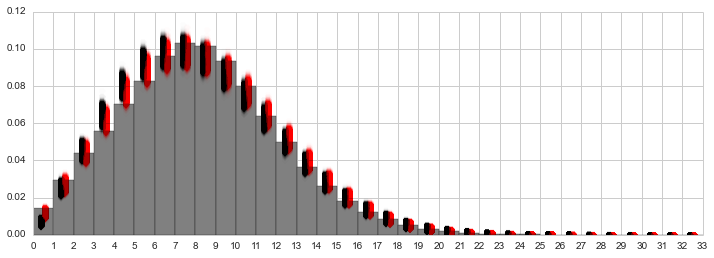

In [349]:
plt.hist(metMastTable.ws_70,bins=np.arange(0,34),
                                       color='grey',normed=True, align='mid') 
fig = plt.gcf()
fig.set_size_inches(12,4)
ax = plt.gca()
ax.set_xlim([0,33])
ax.set_xticks(range(0,34))

f_boot2 = np.zeros((33,N_boot)) #{}
for i in range(N_boot):
    f_boot2[:,i], bins = np.histogram(weibull_min.rvs(c=k_MLE2, loc=loc_MLE2, scale=A_MLE2, size=8742),bins=np.arange(0,34), normed=True)
    ax.plot(x_ws-0.1,f_boot[:,i],'ok',alpha=0.01)
    ax.plot(x_ws+0.1,f_boot2[:,i],'or',alpha=0.01)

### Fitting techniques conclusion
It can be concluded that all of the proposed methods predict similar Weibull parameters with exception of the least square errors based on the histogram and the double logarithm technique. The reason for its different result is due to the fact that the double logarithm technique produces a linear fit in a modified scale which means that the errors in the fit at lower wind speed are considered relatively more important than at higher wind speeds, this will produce problems if used in AEP predictions. Similarly in the minimum sum of squares errors method, the obtained result varies from the other fits, due to the local effect of the binning.

In [177]:
print 'Shape, k\t'+'Scale, A'
print '[-]\t\t'+'[m/s]\t\t'
print '---------------------------------'
print '%0.4f\t\t%0.4f\t EV Fit' % (k_EV, A_EV)
print '%0.4f\t\t%0.4f\t EVSk Fit' % (k_EVSk, A_EVSk)
print '%0.4f\t\t%0.4f\t LL Fit' % (k_LL, A_LL)
print '%0.4f\t\t%0.4f\t MLE' % (k_MLE, A_MLE)
print '%0.4f\t\t%0.4f\t LSE' % (k_LSE, A_LSE)
print
print 'mean\t variance   skewness  kurtosis'
print '%0.4f\t %0.4f    %0.4f    %0.4f   Data' % (E,V,Sk, metMastTable.ws_70.kurt())
print '%0.4f\t %0.4f    %0.4f    %0.4f   EV Fit' % weibull_min.stats(c=k_EV, scale=A_EV,  moments='mvsk')
print '%0.4f\t %0.4f    %0.4f    %0.4f  EVSk Fit' % weibull_min.stats(c=k_EVSk, scale=A_EVSk,  moments='mvsk')
print '%0.4f\t %0.4f    %0.4f    %0.4f   LL Fit' % weibull_min.stats(c=k_LL, scale=A_LL,  moments='mvsk')
print '%0.4f\t %0.4f    %0.4f    %0.4f   MLE Fit' % weibull_min.stats(c=k_MLE, scale=A_MLE,  moments='mvsk')
print '%0.4f\t %0.4f    %0.4f    %0.4f  LSE Fit' % weibull_min.stats(c=k_LSE, scale=A_LSE,  moments='mvsk')

Shape, k	Scale, A
[-]		[m/s]		
---------------------------------
2.2275		9.2987	 EV Fit
2.3911		9.2908	 EVSk Fit
1.8426		8.0651	 LL Fit
2.2103		9.2896	 MLE
2.3332		9.4574	 LSE

mean	 variance   skewness  kurtosis
8.2356	 15.2718    0.4092    0.1415   Data
8.2356	 15.2718    0.4934    0.0186   EV Fit
8.2356	 13.4504    0.4092    -0.0894  EVSk Fit
7.1647	 16.2611    0.7447    0.4787   LL Fit
8.2273	 15.4538    0.5029    0.0322   MLE Fit
8.3800	 14.5513    0.4378    -0.0553  LSE Fit


### 5. Wind Rose
This section consists in estimating the PDF of the mean wind directions by defining regions (or bins) to group the data into. Furthermore the a Weibull distribution for mean wind speed will be perfromed in each of the mean wind direction sector. Initially the wind rose will be computed individually for each of the wind vanes at each height to verify if there is wind veer (vertical distribution of mean wind direction).

In [178]:
metMastTable_67p5.wd_67p5[metMastTable_67p5.wd_67p5>345] = metMastTable_67p5.wd_67p5[metMastTable_67p5.wd_67p5>345]-360
metMastTable_70.wd_70[metMastTable_70.wd_70>345] = metMastTable_70.wd_70[metMastTable_70.wd_70>345]-360

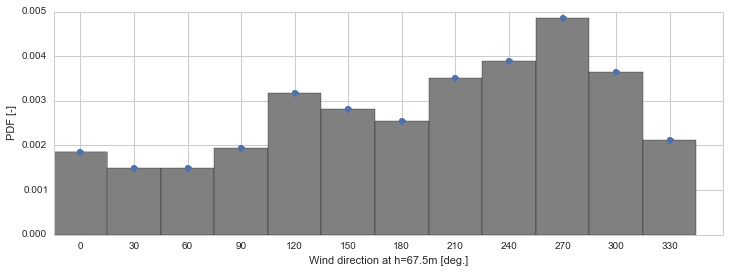

In [179]:
(f_wd_67p5, bins_wd_67p5, patches_ws) = plt.hist(metMastTable_67p5.wd_67p5,bins=30*np.arange(0,13)-15,
                                       color='grey',normed=True, align='mid')
x_wd_67p5 = 0.5*(bins_wd_67p5[:-1]+bins_wd_67p5[1:])
plt.plot(x_wd_67p5,f_wd_67p5,'o')
plt.xlabel('Wind direction at h=67.5m [deg.]')
plt.ylabel('PDF [-]')
fig = plt.gcf()
fig.set_size_inches(12,4)
ax = plt.gca()
ax.set_xlim([-15,360])
ax.set_xticks(range(0,360,30))
print

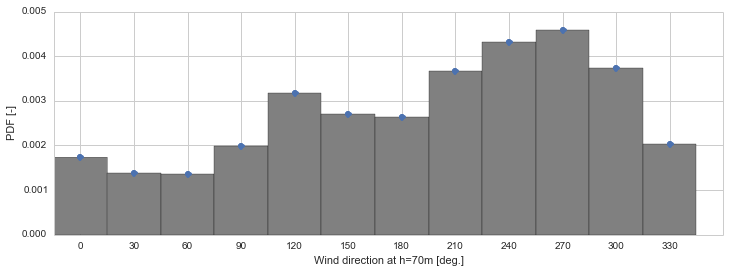

In [180]:
(f_wd_70, bins_wd_70, patches_ws) = plt.hist(metMastTable_70.wd_70,bins=30*np.arange(0,13)-15,
                                       color='grey',normed=True, align='mid')
x_wd_70 = 0.5*(bins_wd_70[:-1]+bins_wd_70[1:])
plt.plot(x_wd_70,f_wd_70,'o')
plt.xlabel('Wind direction at h=70m [deg.]')
plt.ylabel('PDF [-]')
fig = plt.gcf()
fig.set_size_inches(12,4)
ax = plt.gca()
ax.set_xlim([-15,360])
ax.set_xticks(range(0,360,30))
print

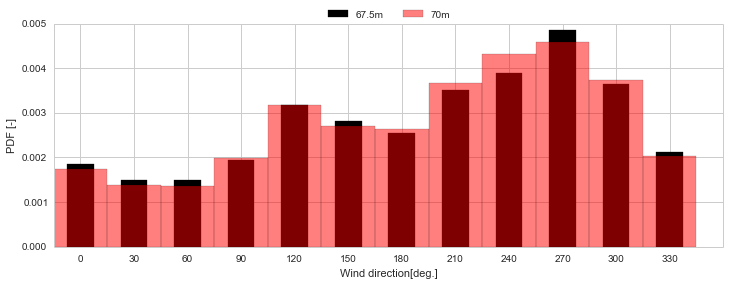

In [181]:
plt.bar(x_wd_67p5-7.5,f_wd_67p5,color='black',width=15,label='67.5m')
plt.bar(x_wd_70-15,f_wd_70,color='red',width=30,label='70m',alpha=0.5)
plt.xlabel('Wind direction[deg.]')
plt.ylabel('PDF [-]')
fig = plt.gcf()
fig.set_size_inches(12,4)
ax = plt.gca()
ax.set_xlim([-15,360])
ax.set_xticks(range(0,360,30))
ax.legend(loc='upper center',bbox_to_anchor=(0.5, 1.1),fancybox=True, shadow=False, ncol=2)
print

From the previous figure it can be observed that there were no major differences in the wind direction distribution from the different time and height of measure, or between the sensor set-up. Even though this is the case, each sensor will be consider individually, since more knowledge about the vertical wind distribution is required in order to consider the two measures as being obtained from the same random variable. 

### 6. Weibull fit for each wind direction bin
Here only the method of mean an skewness is used.

In [355]:
wd_bins = 30*np.arange(0,13)-15
k_67p5 = np.zeros((12))
A_67p5 = np.zeros((12))
loc_67p5 = np.zeros((12))
k_70 = np.zeros((12))
A_70 = np.zeros((12))
loc_70 = np.zeros((12))

In [369]:
for i in range(12):    
    #E  = metMastTable_67p5.ws_70[(metMastTable_67p5.wd_67p5>wd_bins[i])&(metMastTable_67p5.wd_67p5<=wd_bins[i+1])].mean()
    #V  = metMastTable_67p5.ws_70[(metMastTable_67p5.wd_67p5>wd_bins[i])&(metMastTable_67p5.wd_67p5<=wd_bins[i+1])].var()
    #Sk = metMastTable_67p5.ws_70[(metMastTable_67p5.wd_67p5>wd_bins[i])&(metMastTable_67p5.wd_67p5<=wd_bins[i+1])].skew()
    #A_67p5[i], k_67p5[i] = sp.optimize.fsolve(weibull_EVSk, [10,2],args=(E,V,Sk), xtol=1e-6, maxfev=1000)
    ws_67p5  = metMastTable_67p5.ws_70[(metMastTable_67p5.wd_67p5>wd_bins[i])&(metMastTable_67p5.wd_67p5<=wd_bins[i+1])].values
    k_67p5[i],loc_67p5[i],A_67p5[i]= weibull_min.fit(np.sort(ws_67p5[ws_67p5>=0]),
                                 loc=0,shape=2,scale=10)
    
    #E  = metMastTable_70.ws_70[(metMastTable_70.wd_70>wd_bins[i])&(metMastTable_70.wd_70<=wd_bins[i+1])].mean()
    #V  = metMastTable_70.ws_70[(metMastTable_70.wd_70>wd_bins[i])&(metMastTable_70.wd_70<=wd_bins[i+1])].var()
    #Sk = metMastTable_70.ws_70[(metMastTable_70.wd_70>wd_bins[i])&(metMastTable_70.wd_70<=wd_bins[i+1])].skew()
    #A_70[i], k_70[i] = sp.optimize.fsolve(weibull_EVSk, [10,2],args=(E,V,Sk), xtol=1e-6, maxfev=1000)
    ws_70  = metMastTable_70.ws_70[(metMastTable_70.wd_70>wd_bins[i])&(metMastTable_70.wd_70<=wd_bins[i+1])].values
    k_70[i],loc_70[i],A_70[i]= weibull_min.fit(np.sort(ws_70[ws_70>=0]),
                                 loc=0,shape=2,scale=10)
    

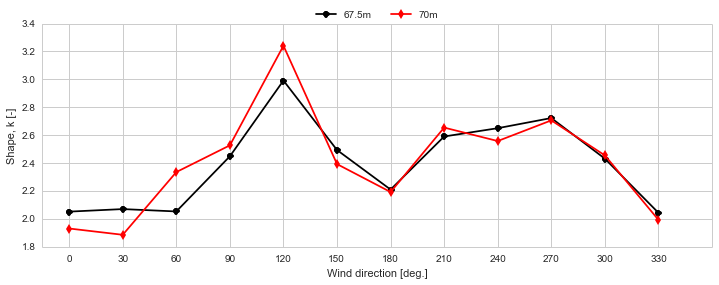

In [370]:
plt.plot(x_wd_70,k_67p5,'-ok',label='67.5m')
plt.plot(x_wd_70,k_70,'-dr',label='70m')
plt.xlabel('Wind direction [deg.]')
plt.ylabel('Shape, k [-]')
fig = plt.gcf()
fig.set_size_inches(12,4)
ax = plt.gca()
ax.set_xlim([-15,360])
ax.set_xticks(range(0,360,30))
ax.legend(loc='upper center',bbox_to_anchor=(0.5, 1.1),fancybox=True, shadow=False, ncol=2)
print

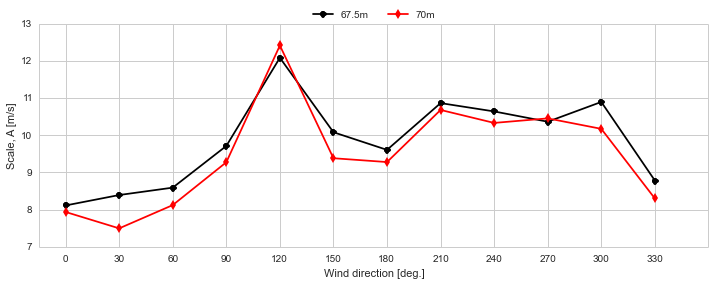

In [371]:
plt.plot(x_wd_70,A_67p5,'-ok',label='67.5m')
plt.plot(x_wd_70,A_70,'-dr',label='70m')
plt.xlabel('Wind direction [deg.]')
plt.ylabel('Scale, A [m/s]')
fig = plt.gcf()
fig.set_size_inches(12,4)
ax = plt.gca()
ax.set_xlim([-15,360])
ax.set_xticks(range(0,360,30))
ax.legend(loc='upper center',bbox_to_anchor=(0.5, 1.1),fancybox=True, shadow=False, ncol=2)
print

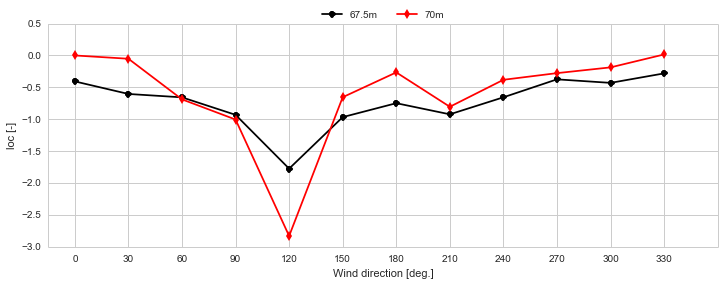

In [374]:
plt.plot(x_wd_70,loc_67p5,'-ok',label='67.5m')
plt.plot(x_wd_70,loc_70,'-dr',label='70m')
plt.xlabel('Wind direction [deg.]')
plt.ylabel('loc [-]')
fig = plt.gcf()
fig.set_size_inches(12,4)
ax = plt.gca()
ax.set_xlim([-15,360])
ax.set_xticks(range(0,360,30))
ax.legend(loc='upper center',bbox_to_anchor=(0.5, 1.1),fancybox=True, shadow=False, ncol=2)
print

105 135



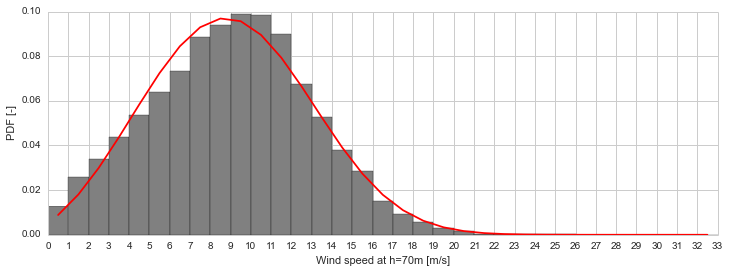

In [381]:
i=4
print wd_bins[i], wd_bins[i+1]
plt.hist(metMastTable_67p5.ws_70[(metMastTable_67p5.wd_67p5>wd_bins[i])&(metMastTable_67p5.wd_67p5<=wd_bins[i+1])],bins=np.arange(0,34),color='grey',
                                       normed=True, align='mid')
plt.plot(x_ws,weibull_min.pdf(x_ws, c=k_67p5[i], loc=loc_67p5[i], scale=A_67p5[i]),'-r')
plt.xlabel('Wind speed at h=70m [m/s]')
plt.ylabel('PDF [-]')
fig = plt.gcf()
fig.set_size_inches(12,4)
ax = plt.gca()
ax.set_xlim([0,33])
ax.set_xticks(range(0,34))
print

105 135



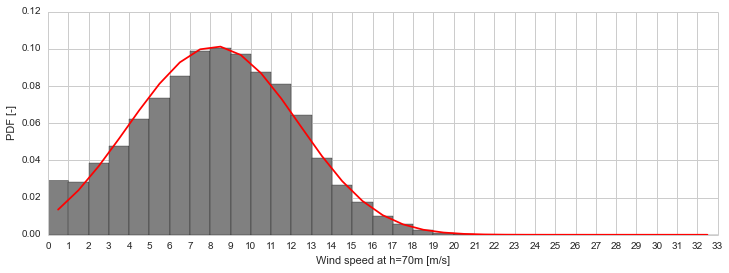

In [382]:
i=4
print wd_bins[i], wd_bins[i+1]
plt.hist(metMastTable_70.ws_70[(metMastTable_70.wd_70>wd_bins[i])&(metMastTable_70.wd_70<=wd_bins[i+1])],bins=np.arange(0,34),color='grey',
                                       normed=True, align='mid')
plt.plot(x_ws,weibull_min.pdf(x_ws, c=k_70[i], loc=loc_70[i], scale=A_70[i]),'-r')
plt.xlabel('Wind speed at h=70m [m/s]')
plt.ylabel('PDF [-]')
fig = plt.gcf()
fig.set_size_inches(12,4)
ax = plt.gca()
ax.set_xlim([0,33])
ax.set_xticks(range(0,34))
print

From the previous two plots it can be observed how the mean wind speed distribution varies over the different wind directions. This is a decomposition of a complex joint probability distribution in terms of the marginal PDF for wind direction and the conditional PDF for the mean wind speed given the wind direction.

$ \text{PDF}(\overline{u},\overline{\theta}) =  \text{PDF}(\overline{u} | \overline{\theta}) \,  \text{PDF}(\overline{\theta})$

In addition, there is a considerable difference in the analysis when the wind direction is taken at different heights; this could be due to the different sensor calibration (hence not a physical process), or due to different vertical distribution of wind direction over height which will be associated to different atmospheric stability conditions. It can also be observed that the principal, most likely, wind direction is the west-east direction, but that the maximum mean wind speeds may occur in a different wind direction bin, as resulted from the Weibull scale parameter distribution. 

### 7. Conclusions

From this study the following conclusions are proposed:

* Several methods for Weibull fitting were proposed and compared. MLE, mean and variance fit and mean and skewness method produce similar Weibul distrutions. The double logarithm technique should be avoided as it gives erroneous fits due to its modified scale of least square linear fit. 

* The joint probability of mean wind speed and wind direction can be decomposed into a wind rose, or the marginal PDF of wind direction occurence and the conditional probability of observing a mean wind speed given a mean wind direction.

* Wind veer, or mean win direction vertical distribution can be expected in the wind directions between 0 to 180 [deg.]. Little information regarding this phenomena is available, since the two measurements occured also at different periods of time.
